This first spreadsheet is to create a simple baseline using a basic random forest model with minimal data prepocessing work. 

# Data Preprocessing

First I've imported all of fastai which includes pandas and numpy. Then I'll import some of the other functionality I'll need. Next I uploaded the train and test csv files as dataframes and then show their heads just to see what the columns contain. 

In [1]:
from fastai.imports import *

#from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeRegressor

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


Below I wanted to see the characteristics of both the continuous and the categorical data. From the competition description RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck are the amounts the passenger has billed at each of the Spaceship Titanic's many luxury amenities. Age has much smaller values than the other continuous values and I may want to look at evening these out in the future. 

In the categorical data there are a small number of categories for HomePlanet, CryoSleep, Destination and VIP. 

In [5]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
train.describe(include=object)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


It's interesting that most of the columns have between 179 and 217 missing data fields. Almost all the columns have missing data and the range is very tight. However out of 8693 rows this missing data amounts to only about 2% of the total rows. But the random forest model will need to multiply a coefficient by each value. This can't be done for the missing values. So I'll need to replace the missing values with a number. The easiest way to do this is to replace them with the mode of a column. The mode is the number that occurs most often in a set of values.

In [7]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
modes = train.mode().iloc[0]
modes

PassengerId                0001_01
HomePlanet                   Earth
CryoSleep                    False
Cabin                      G/734/S
Destination            TRAPPIST-1e
Age                           24.0
VIP                          False
RoomService                    0.0
FoodCourt                      0.0
ShoppingMall                   0.0
Spa                            0.0
VRDeck                         0.0
Name            Alraium Disivering
Transported                   True
Name: 0, dtype: object

Below the function will fill all the NaaNs with the modes identified above. Inplace=True simply means that this will be done in the current dataframe and won't need to create a new dataframe.

In [9]:
#YES
train.fillna(modes, inplace=True)

In [10]:
train.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

I'll need to do the same thing with the test dataframe. 

In [11]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [12]:
modes = test.mode().iloc[0]
modes

PassengerId              0013_01
HomePlanet                 Earth
CryoSleep                  False
Cabin                    G/160/P
Destination          TRAPPIST-1e
Age                         18.0
VIP                        False
RoomService                  0.0
FoodCourt                    0.0
ShoppingMall                 0.0
Spa                          0.0
VRDeck                       0.0
Name            Berta Barnolderg
Name: 0, dtype: object

In [13]:
#YES
test.fillna(modes, inplace=True)

In [14]:
test.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

I want to do the easiest separation of continuous and categorical variables possible, so I'm using cont_cat_split. 

In [15]:
#YES
cont,cat = cont_cat_split(train)

We can see that now the continuous and categorical columns are identified. 

In [16]:
cont

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [17]:
cat

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name',
 'Transported']

In [19]:
train[cat]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,True
...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,True,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,False,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,False,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,False,Celeon Hontichre,False


Then I move through each of the categorical items and transform it into numbers using pd.Categorical. 

In [20]:
#YES
for i in cat:
    train[i] = pd.Categorical(train[i])

Each item appears to be still a text item. 

In [21]:
train[cat].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,True


But behind the scenes python had transformed them to numbers, as you can see with Cabin and HomePlanet. The number is just an index for looking up the value in the list of all unique values. From the describe function above there are 6560 unique values for Cabin and only 3 unique values for HomePlanet. That's why some of the values are so high for Cabin. 

In [22]:
train.Cabin.cat.codes.head()

0     149
1    2184
2       1
3       1
4    2186
dtype: int16

In [23]:
train.HomePlanet.cat.codes.head()

0    1
1    0
2    1
3    1
4    0
dtype: int8

Since I will also need the dependent variable of Transported to be a number, I want to confirm that is the case. 

In [24]:
train.Transported.cat.codes.head()

0    0
1    1
2    0
3    0
4    1
dtype: int8

In preparation for setting up the validation dataset I want to remove the target Transported column from the cat values, now that I've converted it to a number, and also identify it as the dependent variable. 

In [25]:
#YES
cat.remove('Transported')

In [26]:
cat

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

In [27]:
#YES
dep='Transported'

In [28]:
train[dep].head()

0    False
1     True
2    False
3    False
4     True
Name: Transported, dtype: category
Categories (2, object): [False, True]

And now I need to also convert the categories in the test dataset to numbers. First I'm creating the test_passid dataframe to ensure the real passenger IDs are linked to these numbers, since I will need to convert these back to categorical data for my Kaggle submission.

In [29]:
#YES
test_passid = pd.DataFrame(test['PassengerId'])

In [30]:
test_passid.head()

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01


Next I break out the categorical data as test_cat and the continuous data as test_cont. Then I convert each column in test_cat into continuous data, since the ML model can only work with numbers. 

In [31]:
#YES
test_cont,test_cat = cont_cat_split(test)
for i in test_cat:
    test[i] = pd.Categorical(test[i])

Again, the categorical data appears to still be categorical, but behind the scenes they are encoded into categorical data. 

In [32]:
test[test_cat].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,False,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,False,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,False,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,False,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,False,Brence Harperez


In [33]:
test.HomePlanet.cat.codes.head()

0    0
1    0
2    1
3    1
4    0
dtype: int8

In [34]:
test.PassengerId.cat.codes.head()

0    0
1    1
2    2
3    3
4    4
dtype: int16

I created a PassIDCode column to house the actual numbers so that I can match them back to the categorical data when I create the submission file for the Kaggle contest. 

In [35]:
#YES
test_passid['PassIdCode'] = test.PassengerId.cat.codes

In [36]:
test_passid.head()

,PassengerId,PassIdCode
0,0013_01,0
1,0018_01,1
2,0019_01,2
3,0021_01,3
4,0023_01,4


# Utilizing the Model

I'll need to split the test dataset between the training and validation sections, with 25% being the percent allocated to validation. 

In [37]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(train, test_size=0.25)

#x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25)

Then I'm using this function to return the independent (trn_xs and val_xs) and the dependent variables (trn_y and val_y).

In [38]:
def xs_y(df):
    xs = df[cat+cont].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

The separation appeared to work. 

In [39]:
trn_xs.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
5623,5981_01,Mars,False,F/1140/S,TRAPPIST-1e,False,Harz Quart,27.0,441.0,0.0,397.0,471.0,0.0
5253,5606_01,Europa,True,B/213/S,55 Cancri e,False,Algor Paterpad,45.0,0.0,0.0,0.0,0.0,0.0
478,0515_01,Europa,True,B/20/S,TRAPPIST-1e,False,Alramix Swinvul,50.0,0.0,0.0,0.0,0.0,0.0
1352,1425_02,Earth,True,G/220/P,TRAPPIST-1e,False,Mael Adavisons,1.0,0.0,0.0,0.0,0.0,0.0
5344,5713_01,Earth,False,G/915/P,TRAPPIST-1e,False,Lawren Blangibson,42.0,0.0,29.0,317.0,434.0,45.0


In [40]:
trn_y.head()

5623    False
5253     True
478      True
1352     True
5344     True
Name: Transported, dtype: category
Categories (2, object): [False, True]

These lambda functions return all the categorical data in the training and validation datasets for the independent variables into continuous values.

In [41]:
trn_xs[cat] = trn_xs[cat].apply(lambda x: x.cat.codes)
val_xs[cat] = val_xs[cat].apply(lambda x: x.cat.codes)

Below the dependent Transported categorical data are turned into continuous data. 

In [42]:
trn_y = pd.Categorical(trn_y).codes
val_y = pd.Categorical(val_y).codes

In [43]:
trn_y

array([0, 1, 1, ..., 0, 0, 0], dtype=int8)

Finally, I import and run a basic random forest model on the data. The number of estimators is 100 and the minimum number of samples to split a node is at 5. I tried slightly higher and lower numbers for the samples and they came out worse. 

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

In [93]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.20837166513339467

So there is an error of about 21% on this first simple attempt. 

One nice thing about random forests is that they can give you which variable has the biggest impact. This shows a number of the categories had a stronger impact. 

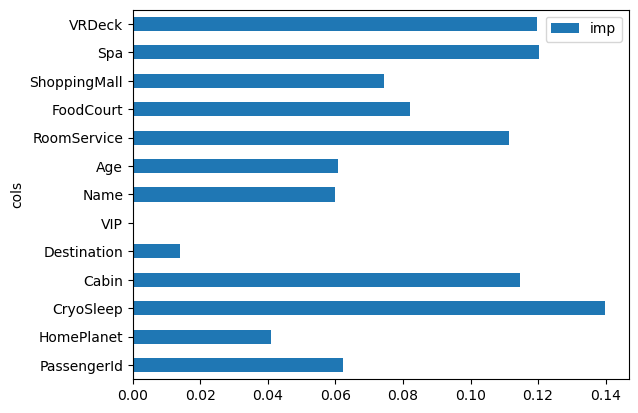

In [67]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

# Create Submission File

I uploaded the submission file and compared it to the test file to make sure it had the same number of rows and that the the Passengerid seemed the same. 

In [68]:
submit = pd.read_csv('sample_submission.csv')

In [69]:
submit.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [70]:
submit.describe()

,PassengerId,Transported
count,4277,4277
unique,4277,1
top,0013_01,False
freq,1,4277


In [150]:
test['PassengerId'].describe()

count        4277
unique       4277
top       0013_01
freq            1
Name: PassengerId, dtype: object

In [151]:
test['PassengerId'].head()

0    0013_01
1    0018_01
2    0019_01
3    0021_01
4    0023_01
Name: PassengerId, dtype: category
Categories (4277, object): ['0013_01', '0018_01', '0019_01', '0021_01', ..., '9269_01', '9271_01', '9273_01', '9277_01']

First I'm converting the test dataset categorical data into their continuous values. Then I'm using the function I used earlier to classify all the current columns in the test dataset as independent variables. 

In [73]:
#YES
test[test_cat] = test[test_cat].apply(lambda x: x.cat.codes)
test_xs,_ = xs_y(test)

In [74]:
test_xs

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,0,1,2784,2,0,2912,27.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1867,2,0,2406,19.0,0.0,9.0,0.0,2823.0,0.0
2,2,1,1,257,0,0,3376,31.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0,259,2,0,2711,38.0,0.0,6652.0,0.0,181.0,585.0
4,4,0,0,1940,2,0,668,20.0,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,4272,0,1,2679,2,0,2105,34.0,0.0,0.0,0.0,0.0,0.0
4273,4273,0,0,2691,2,0,2654,42.0,0.0,847.0,17.0,10.0,144.0
4274,4274,2,1,602,0,0,2085,18.0,0.0,0.0,0.0,0.0,0.0
4275,4275,1,0,603,2,0,2327,18.0,0.0,2680.0,0.0,0.0,523.0


I'm creating the new Transported column in the test dataset as the dependent variable and running the random forest prediction model against the test data. 

In [75]:
test['Transported'] = rf.predict(test_xs)

In [76]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0,1,2784,2,27.0,0,0.0,0.0,0.0,0.0,0.0,2912,1
1,1,0,0,1867,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,2406,0
2,2,1,1,257,0,31.0,0,0.0,0.0,0.0,0.0,0.0,3376,1
3,3,1,0,259,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2711,1
4,4,0,0,1940,2,20.0,0,10.0,0.0,635.0,0.0,0.0,668,0


I need to rename the PassengerId column into a PassCode column so I can next work to match the coded continuous data back to its original categorical data. 

In [77]:
#YES
test.rename(columns={'PassengerId': 'PassCode'}, inplace=True)

In [78]:
test.head()

,PassCode,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,0,1,2784,2,27.0,0,0.0,0.0,0.0,0.0,0.0,2912,1
1,1,0,0,1867,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,2406,0
2,2,1,1,257,0,31.0,0,0.0,0.0,0.0,0.0,0.0,3376,1
3,3,1,0,259,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2711,1
4,4,0,0,1940,2,20.0,0,10.0,0.0,635.0,0.0,0.0,668,0


I need to create a PassengerID categorical data column in the test dataset to match what is in the submit dataset. So where the PassIDCode column from the test_passid dataframe I created earlier matches the PassCode column in the test dataframe, then th PassengerId column in the test dataframe will be filled with the PassengerId value from this earlier test_passid dataframe. Otherwise a NaN value will be created.  

In [79]:
#YES
test['PassengerId'] = np.where(test_passid['PassIdCode'] == test['PassCode'], test_passid['PassengerId'], 'NaN')

In [80]:
test.head()

,PassCode,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId
0,0,0,1,2784,2,27.0,0,0.0,0.0,0.0,0.0,0.0,2912,1,0013_01
1,1,0,0,1867,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,2406,0,0018_01
2,2,1,1,257,0,31.0,0,0.0,0.0,0.0,0.0,0.0,3376,1,0019_01
3,3,1,0,259,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2711,1,0021_01
4,4,0,0,1940,2,20.0,0,10.0,0.0,635.0,0.0,0.0,668,0,0023_01


Below I'm making sure there are no NaN values for the new PassengerId column. 

In [81]:
test['PassengerId'].isna().sum()

0

I'm just moving the PassengerId to the front of the datafram here. 

In [82]:
#TEST
col = test.pop('PassengerId')
test.insert(0, col.name, col)

In [83]:
test.head()

,PassengerId,PassCode,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0013_01,0,0,1,2784,2,27.0,0,0.0,0.0,0.0,0.0,0.0,2912,1
1,0018_01,1,0,0,1867,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,2406,0
2,0019_01,2,1,1,257,0,31.0,0,0.0,0.0,0.0,0.0,0.0,3376,1
3,0021_01,3,1,0,259,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2711,1
4,0023_01,4,0,0,1940,2,20.0,0,10.0,0.0,635.0,0.0,0.0,668,0


Here I'm converting the Transported column back into the True/False boolean values that will be needed for submission. 

In [84]:
#YES
test['Transported'] = np.where(test['Transported'] == 1, 'True', 'False')

In [85]:
test.head()

,PassengerId,PassCode,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0013_01,0,0,1,2784,2,27.0,0,0.0,0.0,0.0,0.0,0.0,2912,True
1,0018_01,1,0,0,1867,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,2406,False
2,0019_01,2,1,1,257,0,31.0,0,0.0,0.0,0.0,0.0,0.0,3376,True
3,0021_01,3,1,0,259,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,2711,True
4,0023_01,4,0,0,1940,2,20.0,0,10.0,0.0,635.0,0.0,0.0,668,False


This creates the actual submission file with this initial benchmark random forest model. 

In [86]:
#YES
submit_benchmark = test[['PassengerId', 'Transported']]

In [87]:
submit_benchmark.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [88]:
#YES
submit_benchmark.to_csv('submit_benchmark.csv', index=False)

For this submission I received a score of 0.7912 which is at position 1234 out of 2248 submissions, which is around the 45th percentile. 